# Universidad de Buenos Aires
# Procesamiento de Lenguaje Natural - Desafio: 2
# Alumno: Matias Werbin

**Consigna:**

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

In [1]:
#!pip install --upgrade gensim

In [2]:
#%pip install nltk

In [3]:
# importacion de librerias
import os
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

**Pre Procesamiento**

In [4]:
# Descargar los datos necesarios para nltk
nltk.download('punkt')

# Ruta de la carpeta de entrenamiento
corpus_path = 'Corpus Entrenamiento'

# Lista de nombres propios
nombres_compuestos = ["Capitán América", "Black Widow", "Iron Man", "Thor", "Hulk", "Hawkeye", "Ant Man", "Doctor Strange", "Thal'gor"]

# Función para leer archivos de texto
def read_files(corpus_path):
    texts = []
    for filename in os.listdir(corpus_path):
        if filename.endswith(".txt"):
            with open(os.path.join(corpus_path, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
    return texts

# Función para tokenizar texto asegurando que los nombres propios no se separen
def custom_tokenizer(text, nombres_compuestos):
    # Reemplazar nombres compuestos por una versión sin espacios
    for nombre in nombres_compuestos:
        text = re.sub(r'\b' + re.escape(nombre) + r'\b', nombre.replace(" ", "_"), text)
    # Tokenizar usando word_tokenize de nltk
    tokens = word_tokenize(text)
    # Revertir el reemplazo de nombres compuestos
    tokens = [token.replace("_", " ") if "_" in token else token for token in tokens]
    return tokens

# Leer archivos
texts = read_files(corpus_path)

# Tokenizar los textos
tokenized_texts = [custom_tokenizer(text, nombres_compuestos) for text in texts]






[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from gensim.models.callbacks import CallbackAny2Vec

#Gensim no imprime loss epoch by epoch. Creamos callback para poder monitorearla
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [6]:
# Inspeccionamos parametros de Word2Vec
# Word2Vec?


Instanciaremos y entrenaremos dos modelos:
1. Skipgram
2. CBOW



1. Skipgram




In [7]:
# Inicializamos el modelo Word2Vec con Skip-gram
model=Word2Vec(min_count=2, # frec min de palabra para incluirla en el vocab
               window=2, # ventana de contexto
               vector_size=20, # dimension de los embeddings
               negative=5, # cant de neg samples--> regularizacion
               workers=1,# seteo en uso de maximos cores en CPU
               seed=74, # Semilla para garantizar reproducibilidad
               sg=1) # Skipgram




In [8]:
# Definimos el Vocabulario
model.build_vocab(tokenized_texts)

# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", model.corpus_count)

# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(model.wv.index_to_key))

Cantidad de docs en el corpus: 3
Cantidad de words distintas en el corpus: 203


**Entrenamiento**

In [9]:
model.train(tokenized_texts,total_examples=model.corpus_count, epochs=80,compute_loss=True, callbacks=[callback()])

Loss after epoch 0: 8850.412109375
Loss after epoch 1: 9076.634765625
Loss after epoch 2: 9090.56640625
Loss after epoch 3: 8827.33203125
Loss after epoch 4: 7731.125
Loss after epoch 5: 6909.5625
Loss after epoch 6: 6409.109375
Loss after epoch 7: 5987.0078125
Loss after epoch 8: 6207.984375
Loss after epoch 9: 6160.7890625
Loss after epoch 10: 5954.3359375
Loss after epoch 11: 5779.890625
Loss after epoch 12: 5836.2734375
Loss after epoch 13: 5847.25
Loss after epoch 14: 5766.5078125
Loss after epoch 15: 5928.9921875
Loss after epoch 16: 5726.1953125
Loss after epoch 17: 5612.0
Loss after epoch 18: 5819.546875
Loss after epoch 19: 5790.0
Loss after epoch 20: 5856.953125
Loss after epoch 21: 5827.15625
Loss after epoch 22: 5712.984375
Loss after epoch 23: 5972.921875
Loss after epoch 24: 5816.765625
Loss after epoch 25: 5977.796875
Loss after epoch 26: 5735.453125
Loss after epoch 27: 5648.25
Loss after epoch 28: 5565.765625
Loss after epoch 29: 5906.25
Loss after epoch 30: 5740.125
L

(57515, 154880)

**Ensayos**

In [10]:
# Analizamos las 10 palabras que mas similaridad tienen con Mjlonir
model.wv.most_similar(positive=["Mjolnir"], topn=3)

[('toda', 0.9500389099121094),
 ('Odín', 0.914953887462616),
 ('inquebrantable', 0.9142495393753052)]

Dentro de las palabras más similares a Mjolnir encontramos dos que se relacionan directamente que son *martillo y energía*, la primera dado que mjlonir es un **martillo** mágico y la segunda es porque justamente este martillo mágico tiene una gran cantidad de **energía**.

In [11]:
# Analizamos las 10 palabras mas disimiles con Thor
model.wv.most_similar(positive=["Capitán América"], topn=3)

[('sistemas', 0.9558695554733276),
 ('Hulk', 0.9294540286064148),
 ('enemigas', 0.9078893065452576)]

Podemos encontrar lógico que nuestro modelo encuentro como palabras cercanas en el espacio de dimension 20 de Capitán América a **Iron Man**, **Hulk** que son Avengers como tambien a su herramienta de combate que es el **escudo**.

In [12]:
# Probamos encontrar una palabra no presente en el vocabulario.
# Por ejemplo: Thanos
# model.wv.most_similar(negative=["Thanos"]) # arroja un KeyError

In [13]:
# Test de Analogía: Mjolnir es a Thor como el escudo es a Capitán América
model.wv.most_similar(positive=["Mjolnir", "Capitán América"], negative=["Thor"], topn=1)

[('escudo', 0.8744091391563416)]

Podemos observar que el modelo puede capturar relaciones de contexto y pasar correctamente el test de analogía:

**"Mjolnir es a Thor como el escudo es a Capitán América"**

In [14]:
# Test de Analogía: Mjolnir es a Thor como el escudo es a Capitán América
model.wv.most_similar(positive=["martillo", "Capitán América"], negative=["Thor"], topn=1)

[('sistemas', 0.8964235186576843)]

Modificando el test de anología de Mjolinir por martillo el modelo sigue respondiendo bien por que interpreta que Mjolnir y martillo son palabras muy similares lo cuales es real y correcto ya que Mjlonir es el martillo mágico de Thor.

In [15]:
# Test de Analogía: Veamos que arroja la analogía inversa de la anterior
model.wv.most_similar(positive=["escudo", "Thor"], negative=["Capitán América"], topn=1)

[('Mjolnir', 0.9394418597221375)]

 Podemos visualizar que el modelo tambien puede capturar relaciones de contexto inversas y pasar correctamente el siguiente test de analogía:

**"Escudo es a Capitan América como Mjlonir es a Thor"**


In [16]:
# Obtencion de embedding de Thor
thor_emb=model.wv.get_vector('Thor')
print(thor_emb)

[-0.19309668  0.4477433   0.6078294   0.21357037 -0.33706015  0.52680224
  0.04059866  0.07806043 -0.32748193 -0.49487844  0.26004156  0.00195577
  0.38847265  0.27263    -0.18729901  0.52795905 -0.29963717 -0.02989786
  0.4320072  -0.11166549]


In [17]:
# Obtencion de embedding de Capitán América
cap_emb=model.wv.get_vector('Capitán América')
print(cap_emb)

[-0.2453457   0.2290609   0.20760286  0.3223232  -0.5134533  -0.09747443
  0.50887775  0.07025323 -0.39170632 -0.17168291 -0.14350343  0.01598942
 -0.14811169 -0.38803384  0.30122524  0.673259   -0.57148683  0.71402687
  0.3385945   0.05281622]


In [18]:
# Obtencion de embedding de Mjolnir
mjolnir_emb=model.wv.get_vector('Mjolnir')
print(mjolnir_emb)

[-0.012028    0.26657984  0.6268362   0.08734737 -0.46983194  0.512794
  0.22830099  0.5162032  -0.3513458  -0.35422522  0.55341446 -0.04727422
  0.48438296  0.25352725  0.05285228  0.41448262 -0.15492499 -0.04451354
  0.2137872  -0.13095053]


In [19]:
# Obtencion de embedding de martillo
martillo_emb=model.wv.get_vector('martillo')
print(martillo_emb)

[-0.02086922  0.08203518  0.59768635  0.05087654 -0.43831244  0.47939745
  0.1087638   0.43706703 -0.27421167 -0.46402928  0.38309428  0.10691338
  0.4617583   0.5322291  -0.31366205  0.47837752 -0.5752348  -0.01623975
  0.37543574 -0.15788676]


In [20]:
# Test de Analogía usando embeddings
model.wv.most_similar(positive=[mjolnir_emb, cap_emb], negative=[thor_emb], topn=1)

[('Capitán América', 0.8964815139770508)]

In [21]:
# Test de Analogía usando embeddings
model.wv.most_similar(positive=[martillo_emb, cap_emb], negative=[thor_emb], topn=1)

[('sistemas', 0.9084479212760925)]

In [22]:
# Obtencion de embedding de escudo
escudo_emb=model.wv.get_vector('escudo')
print(escudo_emb)

[ 0.03340074  0.1014327   0.4257362   0.08551923 -0.51519006  0.19018412
  0.31658506  0.39245945 -0.5330577  -0.19349363  0.16464764 -0.04256796
 -0.05504612 -0.18718213  0.284994    0.45551026 -0.38894483  0.27242652
  0.20224124 -0.01940324]


In [23]:
# Test de Analogía usando embeddings
model.wv.most_similar(positive=[escudo_emb, thor_emb], negative=[cap_emb], topn=1)

[('Mjolnir', 0.8998527526855469)]

Podemos observar que las tres analogías:
- "Mjolnir es a Thor como escudo es a Capitán América"
- "martillo es a Thor como escudo es a Capitán América"
- "escudo es Capitán América como Mjlonir es Thor"

Son capturadas por nuestro modelo usando sus embeddings correspondientes

2. CBOW

In [24]:
# Inicializamos el modelo Word2Vec con Skip-gram
model_cbow=Word2Vec(min_count=2, window=2,vector_size=20,negative=5,workers=1,seed=10,sg=0)

In [25]:
# Definimos el Vocabulario
model_cbow.build_vocab(tokenized_texts)

# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", model_cbow.corpus_count)

# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(model_cbow.wv.index_to_key))

Cantidad de docs en el corpus: 3
Cantidad de words distintas en el corpus: 203


**Entrenamiento**

In [26]:
model_cbow.train(tokenized_texts,total_examples=model_cbow.corpus_count, epochs=80,compute_loss=True, callbacks=[callback()])

Loss after epoch 0: 2928.01708984375
Loss after epoch 1: 2918.3984375
Loss after epoch 2: 3033.11669921875
Loss after epoch 3: 3019.0576171875
Loss after epoch 4: 2869.6015625
Loss after epoch 5: 3056.146484375
Loss after epoch 6: 2953.326171875
Loss after epoch 7: 2811.583984375
Loss after epoch 8: 2647.2421875
Loss after epoch 9: 2422.033203125
Loss after epoch 10: 2324.021484375
Loss after epoch 11: 2247.400390625
Loss after epoch 12: 2202.2578125
Loss after epoch 13: 2168.00390625
Loss after epoch 14: 2159.83203125
Loss after epoch 15: 1964.41796875
Loss after epoch 16: 1930.640625
Loss after epoch 17: 1904.55859375
Loss after epoch 18: 1974.6171875
Loss after epoch 19: 2032.453125
Loss after epoch 20: 2054.59375
Loss after epoch 21: 1968.96484375


Loss after epoch 22: 1969.171875
Loss after epoch 23: 1994.67578125
Loss after epoch 24: 1861.85546875
Loss after epoch 25: 1961.77734375
Loss after epoch 26: 1982.5703125
Loss after epoch 27: 1947.91015625
Loss after epoch 28: 1926.05078125
Loss after epoch 29: 2001.1171875
Loss after epoch 30: 1947.6640625
Loss after epoch 31: 1964.4765625
Loss after epoch 32: 1958.6875
Loss after epoch 33: 1998.828125
Loss after epoch 34: 2060.0703125
Loss after epoch 35: 1931.09375
Loss after epoch 36: 1937.0078125
Loss after epoch 37: 1946.03125
Loss after epoch 38: 1907.828125
Loss after epoch 39: 1960.1796875
Loss after epoch 40: 1983.46875
Loss after epoch 41: 1936.8359375
Loss after epoch 42: 1968.6875
Loss after epoch 43: 1961.1640625
Loss after epoch 44: 1933.6640625
Loss after epoch 45: 1986.8515625
Loss after epoch 46: 1884.15625
Loss after epoch 47: 1980.34375
Loss after epoch 48: 1938.1328125
Loss after epoch 49: 1956.40625
Loss after epoch 50: 1936.6484375
Loss after epoch 51: 1915.9765

(57569, 154880)

In [27]:
model_cbow.wv.most_similar(positive=['Mjolnir'],topn=10)

[('su', 0.9915413856506348),
 ('combatientes', 0.9895226955413818),
 ('paz', 0.9893936514854431),
 ('rugido', 0.9864608645439148),
 ('agradeciendo', 0.9864513278007507),
 ('del', 0.9863694310188293),
 ('toda', 0.9863158464431763),
 ('lanzó', 0.986156165599823),
 ('corazón', 0.9857831001281738),
 ('siempre', 0.9855009913444519)]

Podemos observar que varias de las palabras con similud con Mjolnir se espera que aparezcan en el mismo contexto o cercanas en una oración como ser: martillo (Mjolonir es un martlllo) , levantó (Thor es el unico que puede LEVANTA a Mjlonir) , reino (relación dado que es un arma del reino de Asgard como tambien es nombrada en la batalla con el resto de los reinos), arma (Mjolnir es un arma), entre otras.

In [28]:
model_cbow.wv.most_similar(positive=['escudo','Thor'],negative=['Capitán América'],topn=10)

[(',', 0.980392575263977),
 ('pura', 0.9781437516212463),
 ('el', 0.9779212474822998),
 ('del', 0.9774328470230103),
 ('energía', 0.9773322343826294),
 ('siempre', 0.9744370579719543),
 ('armadura', 0.9743768572807312),
 ('para', 0.9743447303771973),
 ('era', 0.9743066430091858),
 ('había', 0.973618745803833)]

Podemos observar que el modelo con CBOW responde bien con la analogía:
- "escudo es a Cápitan América como Mjolnir/martillo es a Thor"

Dado que tanto martillo como Mjolnir son encontradas en la sentencia anterior.

Para visualizar usaremos el modelo realizado con skipgram

In [29]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=74)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [30]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(model)

MAX_WORDS=203
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab")

ModuleNotFoundError: No module named 'plotly'

In [ ]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab")

Al graficar los embeddings, luego de reducir dimensionalidad con t-sne podemos observar lo siguiente:

- Los embeddings de Black Widow, Hulk, Iron Man, Hawkeye y Capitán América se encuentran cerca que puede considerarse correcto ya que todos son Avengers

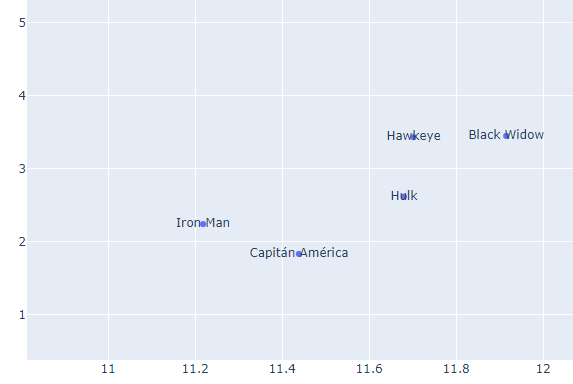

- Los embedding de dios, Trueno, trueno, Asgard, El, el Poderoso, Thor, del, Odin, Mjolinir martillo y Midgard se encuentran cerca y son palabras que se pueden encontrar en el mismo contexto de un texto o muy cerca en un oración.

Por ejemplo encontrar frases El Poderoso Thor, Thor el dios del trueno/Trueno o Mjlonir el martllo.

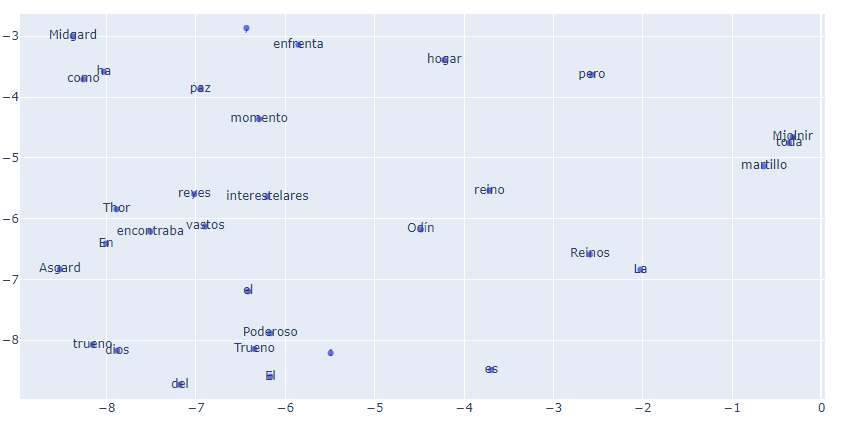


- Los embedding de martillo Xargoth y Thal'gor se encuentran se encuentran cerca y es correcto ya que el modelo los identifico como villanos


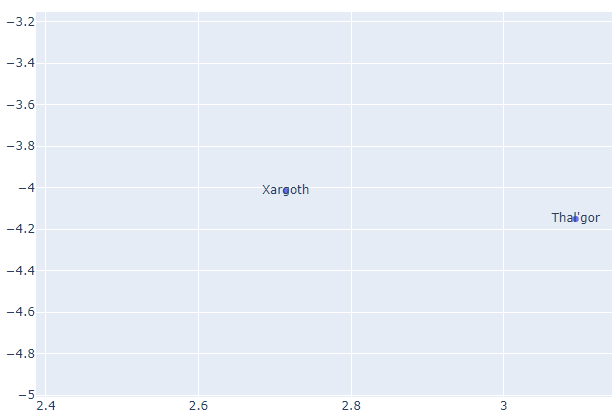

Para una visualización más pretty jugar con hiperparametros podes ingresar: http://projector.tensorflow.org/ pero antes debemos guardar los vectores y labels como tsv:

In [ ]:
vec=np.asarray(model.wv.vectors)
labels=list(model.wv.index_to_key)

np.savetxt("vectors.tsv", vec, delimiter="\t")

with open("labels.tsv","w") as fp:
  for item in labels:
    fp.write("%s\n" % item)

Podemos observar que usando PCA desde el projector de tensorflow podamos observar patrones de cercanias muy similares que lo antes descripto

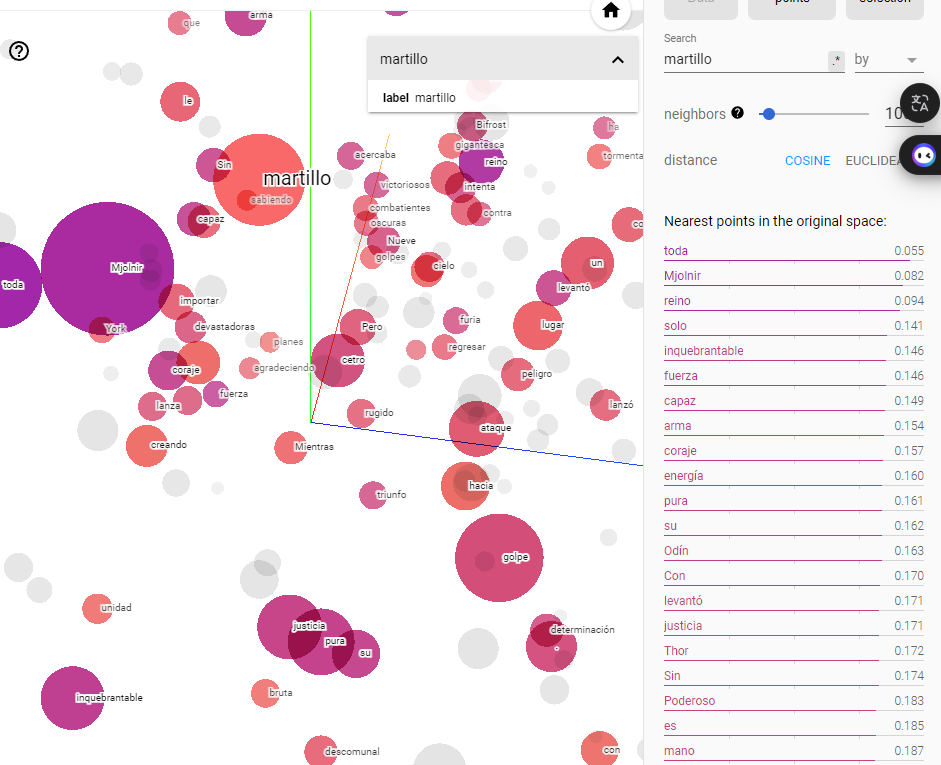

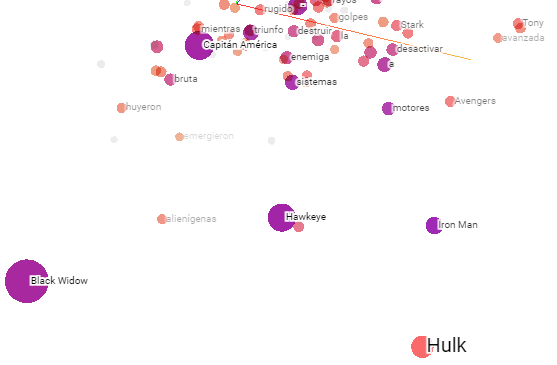